A brief data analysis of some of the worst reviews Yelp has to offer 

In [85]:
#packages to install 
%conda install -c conda-forge wordcloud
%pip install folium
%pip install langdetect


Solving environment: done

# All requested packages already installed.


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [86]:
#logging stuff
import logging 
Log_format = "%(levelname)s %(asctime)s - %(message)s"

logging.basicConfig(filename= "logfile.log",
                    filemode= "w", 
                    format = Log_format,
                    level= logging.WARNING)

logger = logging.getLogger()

#Test that logger 
logger.error("Log this, why don't ya?")

In [87]:
#Packages to import and why 
import numpy as np #math stuff
import pandas as pd #data processing
import nltk #language processing
#from nltk.corpus import stopwords #most common words
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')
import matplotlib.pyplot as plt #data visualization
import seaborn as sns #also data visualization 
import folium #maps
from wordcloud import WordCloud, STOPWORDS
%matplotlib inline 
from langdetect import detect_langs


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/tifanyables/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [88]:
# Read business file 
business = pd.read_csv('/Users/tifanyables/Desktop/Welp/yelp_dataset/yelp_business.csv',  index_col=False)

In [89]:
business.head()

,business_id,name,neighborhood,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,categories
0,FYWN1wneV18bWNgQjJ2GNg,"""Dental by Design""",NaN,"""4855 E Warner Rd, Ste B9""",Ahwatukee,AZ,85044,33.330690,-111.978599,4.0,22,1,Dentists;General Dentistry;Health & Medical;Or...
1,He-G7vWjzVUysIKrfNbPUQ,"""Stephen Szabo Salon""",NaN,"""3101 Washington Rd""",McMurray,PA,15317,40.291685,-80.104900,3.0,11,1,Hair Stylists;Hair Salons;Men's Hair Salons;Bl...
2,KQPW8lFf1y5BT2MxiSZ3QA,"""Western Motor Vehicle""",NaN,"""6025 N 27th Ave, Ste 1""",Phoenix,AZ,85017,33.524903,-112.115310,1.5,18,1,Departments of Motor Vehicles;Public Services ...
3,8DShNS-LuFqpEWIp0HxijA,"""Sports Authority""",NaN,"""5000 Arizona Mills Cr, Ste 435""",Tempe,AZ,85282,33.383147,-111.964725,3.0,9,0,Sporting Goods;Shopping
4,PfOCPjBrlQAnz__NXj9h_w,"""Brick House Tavern + Tap""",NaN,"""581 Howe Ave""",Cuyahoga Falls,OH,44221,41.119535,-81.475690,3.5,116,1,American (New);Nightlife;Bars;Sandwiches;Ameri...


In [90]:
#specific columns from business  
business_cols = business[['business_id','name', 'address', 'state', 'postal_code', 'latitude', 'longitude', 'is_open', 'categories']]

In [91]:
business_cols.head()

,business_id,name,address,state,postal_code,latitude,longitude,is_open,categories
0,FYWN1wneV18bWNgQjJ2GNg,"""Dental by Design""","""4855 E Warner Rd, Ste B9""",AZ,85044,33.330690,-111.978599,1,Dentists;General Dentistry;Health & Medical;Or...
1,He-G7vWjzVUysIKrfNbPUQ,"""Stephen Szabo Salon""","""3101 Washington Rd""",PA,15317,40.291685,-80.104900,1,Hair Stylists;Hair Salons;Men's Hair Salons;Bl...
2,KQPW8lFf1y5BT2MxiSZ3QA,"""Western Motor Vehicle""","""6025 N 27th Ave, Ste 1""",AZ,85017,33.524903,-112.115310,1,Departments of Motor Vehicles;Public Services ...
3,8DShNS-LuFqpEWIp0HxijA,"""Sports Authority""","""5000 Arizona Mills Cr, Ste 435""",AZ,85282,33.383147,-111.964725,0,Sporting Goods;Shopping
4,PfOCPjBrlQAnz__NXj9h_w,"""Brick House Tavern + Tap""","""581 Howe Ave""",OH,44221,41.119535,-81.475690,1,American (New);Nightlife;Bars;Sandwiches;Ameri...


In [92]:
#only restaurants 
bus_rests = business_cols[business_cols['categories'].str.contains('Restaurant')] 

In [93]:
len(bus_rests)

54630

In [94]:
#only open restarants 
open_rest = bus_rests[bus_rests['is_open']== 1]

In [95]:
len(open_rest)

40405

In [96]:
open_rest.head()

,business_id,name,address,state,postal_code,latitude,longitude,is_open,categories
4,PfOCPjBrlQAnz__NXj9h_w,"""Brick House Tavern + Tap""","""581 Howe Ave""",OH,44221,41.119535,-81.475690,1,American (New);Nightlife;Bars;Sandwiches;Ameri...
5,o9eMRCWt5PkpLDE0gOPtcQ,"""Messina""","""Richterstr. 11""",BW,70567,48.727200,9.147950,1,Italian;Restaurants
14,fNMVV_ZX7CJSDWQGdOM8Nw,"""Showmars Government Center""","""600 E 4th St""",NC,28202,35.221647,-80.839345,1,Restaurants;American (Traditional)
19,Gu-xs3NIQTj3Mj2xYoN2aw,"""Maxim Bakery & Restaurant""","""9665 Bayview Avenue, Unit 1-4""",ON,L4C 9V4,43.867565,-79.412662,1,French;Food;Bakeries;Restaurants
25,1K4qrnfyzKzGgJPBEcJaNQ,"""Chula Taberna Mexicana""","""1058 Gerrard Street E""",ON,M4M 3A6,43.669256,-79.335902,1,Tiki Bars;Nightlife;Mexican;Restaurants;Bars


In [97]:
#drop unneeded columns and reset index 
open_rest = open_rest.drop(columns=['is_open', 'categories']).reset_index(drop=True)

In [98]:
open_rest.head()

,business_id,name,address,state,postal_code,latitude,longitude
0,PfOCPjBrlQAnz__NXj9h_w,"""Brick House Tavern + Tap""","""581 Howe Ave""",OH,44221,41.119535,-81.475690
1,o9eMRCWt5PkpLDE0gOPtcQ,"""Messina""","""Richterstr. 11""",BW,70567,48.727200,9.147950
2,fNMVV_ZX7CJSDWQGdOM8Nw,"""Showmars Government Center""","""600 E 4th St""",NC,28202,35.221647,-80.839345
3,Gu-xs3NIQTj3Mj2xYoN2aw,"""Maxim Bakery & Restaurant""","""9665 Bayview Avenue, Unit 1-4""",ON,L4C 9V4,43.867565,-79.412662
4,1K4qrnfyzKzGgJPBEcJaNQ,"""Chula Taberna Mexicana""","""1058 Gerrard Street E""",ON,M4M 3A6,43.669256,-79.335902


Review Stuff

In [99]:
# Read review file 
review = pd.read_csv('/Users/tifanyables/Desktop/Welp/yelp_dataset/yelp_review.csv')

In [100]:
len(review)

5261668

In [101]:
#drop unneeded columns and reset index 
review = review.drop(columns=['review_id', 'user_id'])

In [102]:
rest_ids = set(open_rest['business_id'])

In [103]:
# filter out any place that isn't in rest ids
rest_reviews = review[review['business_id'].isin(rest_ids)]

In [104]:
rest_reviews.head()

,business_id,stars,date,text,useful,funny,cool
0,AEx2SYEUJmTxVVB18LlCwA,5,2016-05-28,Super simple place but amazing nonetheless. It...,0,0,0
1,VR6GpWIda3SfvPC-lg9H3w,5,2016-05-28,Small unassuming place that changes their menu...,0,0,0
2,CKC0-MOWMqoeWf6s-szl8g,5,2016-05-28,Lester's is located in a beautiful neighborhoo...,0,0,0
3,ACFtxLv8pGrrxMm6EgjreA,4,2016-05-28,Love coming here. Yes the place always needs t...,0,0,0
4,s2I_Ni76bjJNK9yG60iD-Q,4,2016-05-28,Had their chocolate almond croissant and it wa...,0,0,0


In [105]:
rest_reviews['business_id'].nunique()

40405

In [106]:
len(rest_reviews)

2774509

In [107]:
rest_reviews.head()

,business_id,stars,date,text,useful,funny,cool
0,AEx2SYEUJmTxVVB18LlCwA,5,2016-05-28,Super simple place but amazing nonetheless. It...,0,0,0
1,VR6GpWIda3SfvPC-lg9H3w,5,2016-05-28,Small unassuming place that changes their menu...,0,0,0
2,CKC0-MOWMqoeWf6s-szl8g,5,2016-05-28,Lester's is located in a beautiful neighborhoo...,0,0,0
3,ACFtxLv8pGrrxMm6EgjreA,4,2016-05-28,Love coming here. Yes the place always needs t...,0,0,0
4,s2I_Ni76bjJNK9yG60iD-Q,4,2016-05-28,Had their chocolate almond croissant and it wa...,0,0,0


In [108]:
#count of star ratings 
rest_reviews.groupby(['stars']).size().reset_index()

,stars,0
0,1,305702
1,2,257352
2,3,378467
3,4,756626
4,5,1076362


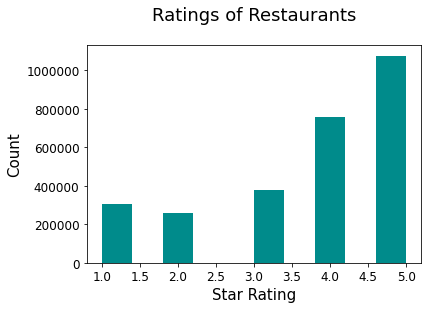

In [109]:
# histplot for star ratings of reviews

rest_reviews['stars'].hist(grid=False, color="darkcyan", xlabelsize=12, ylabelsize=12)
plt.title('Ratings of Restaurants',fontsize=18, pad=25.0) 
plt.xlabel("Star Rating", fontsize=15)
plt.ylabel("Count", fontsize=15)
plt.ticklabel_format(style='plain', axis='y',useOffset=False)
plt.show()

In [110]:
# histplot for review classification, maybe?  
# --- sns.histplot()
# --- plt.show() 


In [111]:
rest_reviews.set_index('business_id', inplace=True)
open_rest.set_index('business_id', inplace=True)


In [112]:
# filter out only 1 star reviews
one_stars = rest_reviews.loc[rest_reviews['stars'] == 1] 

# show first results --  one_star_df.head()

One star reviews for open restaurants with business info attached 

In [113]:
#combine csvs into mega csv 
one_star_reviews= open_rest.merge(one_stars, on= ["business_id"])

In [114]:
# I literally don't care about this at all
# one_star_reviews['date'] = pd.to_datetime(one_star_reviews['date'])

In [115]:
one_star_reviews.head()

,name,address,state,postal_code,latitude,longitude,stars,date,text,useful,funny,cool
business_id,,,,,,,,,,,,
PfOCPjBrlQAnz__NXj9h_w,"""Brick House Tavern + Tap""","""581 Howe Ave""",OH,44221,41.119535,-81.47569,1,2015-08-31,Worse service ever andI use to be a server so ...,0,0,0
PfOCPjBrlQAnz__NXj9h_w,"""Brick House Tavern + Tap""","""581 Howe Ave""",OH,44221,41.119535,-81.47569,1,2011-08-22,1st and foremost I will tell you the food here...,7,8,0
PfOCPjBrlQAnz__NXj9h_w,"""Brick House Tavern + Tap""","""581 Howe Ave""",OH,44221,41.119535,-81.47569,1,2015-09-22,Do not recommend. Ordered a lamb burger medium...,0,0,0
PfOCPjBrlQAnz__NXj9h_w,"""Brick House Tavern + Tap""","""581 Howe Ave""",OH,44221,41.119535,-81.47569,1,2015-03-01,So my family and I went to Brickhouse yesterda...,0,1,0
PfOCPjBrlQAnz__NXj9h_w,"""Brick House Tavern + Tap""","""581 Howe Ave""",OH,44221,41.119535,-81.47569,1,2011-10-29,Sitting here and not wanting to wait until I l...,2,9,0


In [116]:
one_star_reviews = one_star_reviews.drop(columns=['useful', 'funny', 'cool']).reset_index(drop=True)

In [117]:
one_star_reviews.head()

,name,address,state,postal_code,latitude,longitude,stars,date,text
0,"""Brick House Tavern + Tap""","""581 Howe Ave""",OH,44221,41.119535,-81.47569,1,2015-08-31,Worse service ever andI use to be a server so ...
1,"""Brick House Tavern + Tap""","""581 Howe Ave""",OH,44221,41.119535,-81.47569,1,2011-08-22,1st and foremost I will tell you the food here...
2,"""Brick House Tavern + Tap""","""581 Howe Ave""",OH,44221,41.119535,-81.47569,1,2015-09-22,Do not recommend. Ordered a lamb burger medium...
3,"""Brick House Tavern + Tap""","""581 Howe Ave""",OH,44221,41.119535,-81.47569,1,2015-03-01,So my family and I went to Brickhouse yesterda...
4,"""Brick House Tavern + Tap""","""581 Howe Ave""",OH,44221,41.119535,-81.47569,1,2011-10-29,Sitting here and not wanting to wait until I l...


In [118]:
#type(one_star_reviews["longitude"][0])

In [119]:
#sent analysis with a little progress bar, as a treat 
analyzer = SentimentIntensityAnalyzer()

rlen = len(one_star_reviews)
hundredth = int(rlen/100)

compound_scores = []

for i, Review in enumerate(one_star_reviews['text']):
    compound_scores.append(analyzer.polarity_scores(Review)['compound'])
    print((i//hundredth)*'|' + (99-i//hundredth)*' ' + '|', end='\r')

one_star_reviews['compound'] = compound_scores

In [120]:
#add column to df for compound scores
one_star_reviews = one_star_reviews.sort_values(by='compound')

In [121]:
compound_mean = one_star_reviews['compound'].mean()
print(compound_mean)

-0.14635714028692945


In [122]:
worst_mean = one_star_reviews.head(25)['compound'].mean()
print(worst_mean)

-0.9986440000000001


In [123]:
bottom_dwellers = one_star_reviews.head(500)

In [124]:
language = [detect_langs(i) for i in bottom_dwellers.text]
languages = [str(i[0]).split(':')[0] for i in language]
bottom_dwellers['language'] = languages

/var/folders/lf/n1rw9kdd3csgtpmvzst_92pr0000gn/T/ipykernel_2800/2428245652.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bottom_dwellers['language'] = languages


In [125]:
bottom_dwellers.head()

,name,address,state,postal_code,latitude,longitude,stars,date,text,compound,language
107258,"""Ochs'n Willi""","""Kleiner Schloßplatz 4""",BW,70173,48.778022,9.176881,1,2012-03-11,"Wir waren nicht das erste Mal dort, sondern ga...",-0.9992,de
32778,"""Amici""","""Lautenschlagerstr. 2""",BW,70173,48.783228,9.179772,1,2012-12-21,Wir waren gestern (Dez 2012) das erste und let...,-0.9992,de
150424,"""Maredo""","""Lange Str. 9""",BW,70173,48.775570,9.174086,1,2010-04-19,HIER REGIERT DAS PERSONAL!\n\n\n MAREDO STUTTG...,-0.9990,de
169573,"""Essence Bakery Cafe""","""3830 E Indian School Rd""",AZ,85018,33.495457,-111.998597,1,2013-10-21,"You might be asking yourself, ""Lance, why do y...",-0.9990,en
49613,"""Class Restaurant""","""Reinsburg Str. 9""",BW,70178,48.771300,9.170460,1,2009-12-14,"Hallo,\n\n\n wir waren vor kurzem im ""Class"", ...",-0.9990,de


In [126]:
bottom_dwellers = bottom_dwellers[bottom_dwellers['language']== 'en']

In [127]:
bottom_dwellers.head()

,name,address,state,postal_code,latitude,longitude,stars,date,text,compound,language
169573,"""Essence Bakery Cafe""","""3830 E Indian School Rd""",AZ,85018,33.495457,-111.998597,1,2013-10-21,"You might be asking yourself, ""Lance, why do y...",-0.9990,en
176817,"""Jimmy John's""","""5890 W Thunderbird Rd, Ste 103""",AZ,85306,33.611156,-112.185174,1,2016-11-20,I'm actually shocked to see that this location...,-0.9988,en
70022,"""Panera Bread""","""4338 Kent Rd""",OH,44224,41.156195,-81.406175,1,2012-10-07,It was March of last year and my girlfriend at...,-0.9987,en
154731,"""Johnny's""","""112 Westinghouse Ave""",PA,15148,40.392793,-79.810025,1,2017-08-19,Oh no. Johnny's! I've been trying to review yo...,-0.9986,en
163924,"""Saga Hibachi Steakhouse & Sushi Bar""","""1040 Settlers Ridge Center Dr""",PA,15205,40.440513,-80.148515,1,2013-09-08,Never. Again. I can't say that I was particu...,-0.9985,en


In [128]:
#make a basemap 
USA = [37.090240, -95.712891]
Map = folium.Map(USA, zoom_start=4, tiles= "Stamen Toner")
#Map

In [130]:
#add points to that map
#bottom_dwellers = one_star_reviews.head(50)
for i in range(0, len(bottom_dwellers)):
    folium.Marker(
        [bottom_dwellers.iloc[i] ["latitude"], bottom_dwellers.iloc[i]["longitude"]],
        popup=bottom_dwellers.iloc[i]["name"]).add_to(Map)

Map


In [ ]:
bottom_dwellers.head()

In [ ]:
len(bottom_dwellers)

In [ ]:
worst_mean_english = bottom_dwellers['compound'].mean()
print(worst_mean_english)

In [ ]:
# join all reviews and get a count of words to start making a wordcloud also lower case them 
turd_soup= " ".join(bottom_dwellers['text']).lower()

# how many words?  
print ("There are {} words in the combination of the 50 worst reviews.".format(len(bottom_dwellers)))
# how many stopwords? 
print ("There are {} stopwords.".format(len(STOPWORDS))) #how many uselessly common words?
#remove stop words  ???
# how many words with no stop words ???

In [ ]:
# make wordcloud of 1 star reviews with stop words removed  
turd_cloud = WordCloud(stopwords=STOPWORDS, width =3500, height= 2000, max_words=200, random_state=42).generate(turd_soup)

# show wordcloud 
plt.imshow(turd_cloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [ ]:
#individual reviews 
# how many total entries exist in total one_star df? print total number 

# choose a random number to pull a random entry 
# -- entry_number = some number 
# -- single_review = TextBlob(one_stars["text"][entry_number])
# -- single_review 

#analysize it by individual sentences 
# -- for sentence in single_review.sentences:
#   -- print(sentence)
#   -- print(sentence.sentiment,"\n")

